<a href="https://colab.research.google.com/github/vivekmoningi/Gesture_Recognition_with_3D-CNN-and-CNN-RNN-with-Stacked-Model/blob/main/Gesture_Recognition_with_3D_CNN_and_CNN%2BRNN_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
!nvidia-smi

Tue Jul 12 23:54:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=e9da2833497d16266d1101c8ae657ddc302375d0dc2325bf0adbd359fdbe556e
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Gen RAM Free: 25.2 GB  | Proc size: 1.2 GB
GPU RAM Free: 15891MB | Used: 389MB | Util   2% | Total 16280MB


In [4]:
#importing necessary pacakges
import numpy as np
import os
from skimage.transform import resize as imresize
from imageio import imread
import datetime
import os
import math
import cv2 as cv
import matplotlib.pyplot as plt


We set the random seed so that the results don't vary drastically.

In [5]:
#initialising random seed and necessary packages
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)
from tensorflow.keras import layers

In [6]:
# mount google drive folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#copying the file from google drive
!cp '/content/drive/MyDrive/Colab Notebooks/Gesture Recognition Assignment/Project_data/Project_data.zip' '/content/sample_data'

In [8]:
#unzipping the file
!unzip /content/sample_data/Project_data.zip -d /content/sample_data

Streaming output truncated to the last 5000 lines.
 extracting: /content/sample_data/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: /content/sample_data/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: /content/sample_data/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: /content/sample_data/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: /content/sample_data/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: /content/sample_data/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: /content/sample_data/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: /content/sample_data/Project_data/train/WIN_20180926_1

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [9]:
#assigning train, val doc and batch size
train_doc = np.random.permutation(open('/content/sample_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/sample_data/Project_data/val.csv').readlines())
batch_size = 32

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [10]:
# defining a function to crop and resize images
def cropResize(image, y, z):
    h, w = image.shape
    
    # if smaller image crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return imresize(image, (y,z))

In [11]:
# defining function to normalize Images
def normalizeImage(image):
    # applying normalization
    return image/255.0

In [12]:
# preprocessing images step will help in preprocessing images
def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))

In [26]:
def getImgIdx(n_frames):
  img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
  return img_idx
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = getImgIdx(30) #create a list of image numbers you want to use for a particular video
    x = len(img_idx) #x is the number of images you use for each video
    y = 84 #(y,z) is the final size of the input images and 3 is the number of channels RGB
    z = 84 #(y,z) is the final size of the input images and 3 is the number of channels RGB
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                                       
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z)#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z)#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z)#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(folder_list)%batch_size != 0: # Finding total images procees
            remaining_batch_size = len(folder_list)%batch_size # finding remaining images to process
            batch_data = np.zeros((remaining_batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(remaining_batch_size): # iterate over remaining images
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*remaining_batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*remaining_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                   
                    batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z)#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z)#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z)#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [14]:
#assigning train path, val path, num_train_sequences and num_val_sequences
curr_dt_time = datetime.datetime.now()
train_path = '/content/sample_data/Project_data/train'
val_path = '/content/sample_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


In [48]:
"""
#training data metrics
sample_generator_train =  generator(train_path, train_doc, batch_size)
sample_batch_data, sample_batch_labels = next(sample_generator_train)
print(sample_batch_data.shape)

#validation data metrics
sample_generator_val =  generator(val_path, val_doc, batch_size)
sample_batch_data_val, sample_batch_labels_val = next(sample_generator_val)
print(sample_batch_data_val.shape)
"""

'\n#training data metrics\nsample_generator_train =  generator(train_path, train_doc, batch_size)\nsample_batch_data, sample_batch_labels = next(sample_generator_train)\nprint(sample_batch_data.shape)\n\n#validation data metrics\nsample_generator_val =  generator(val_path, val_doc, batch_size)\nsample_batch_data_val, sample_batch_labels_val = next(sample_generator_val)\nprint(sample_batch_data_val.shape)\n'

In [49]:
"""
# plotting images
fig, axs = plt.subplots(1,2)
axs[0].imshow(sample_batch_data_val[10,10,:,:,:])
axs[1].imshow(sample_batch_data_val[30,10,:,:,:])
plt.show()
"""

'\n# plotting images\nfig, axs = plt.subplots(1,2)\naxs[0].imshow(sample_batch_data_val[10,10,:,:,:])\naxs[1].imshow(sample_batch_data_val[30,10,:,:,:])\nplt.show()\n'

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [37]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, LSTM, Dropout, Input, MaxPool3D, ZeroPadding3D
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D, Conv2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from tensorflow.keras.optimizers import Adam

### Building Models
 We will be building 3 models
 1. CNN + 3D
 2. CNN + LSTM
 3. CNN + GRU

Lets start with CNN + 3D model

# Initial Model

In [43]:
# building 3D Model
class ModelBuilding(object):
  def cnn_3d(self,input_shape,no_classes):
      model = Sequential()
      model.add(Conv3D(16,kernel_size=(3,3,3), input_shape=input_shape, activation = 'relu'))
      model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))
      model.add(BatchNormalization())
      model.add(Dropout(0.25))
      

      model.add(Conv3D(32,kernel_size=(3,3,3),activation = 'relu'))      
      model.add(MaxPooling3D(pool_size=(1,2,2), strides=(2,2,2), padding='same'))
      model.add(BatchNormalization())
      model.add(Dropout(0.25))


      model.add(Conv3D(64,kernel_size=(3,3,3),activation = 'relu'))
      model.add(MaxPooling3D(pool_size=(1,2,2), strides=(2,2,2), padding='same'))
      model.add(BatchNormalization())
      model.add(Dropout(0.25))     

      #Flatten Layers
      model.add(Flatten())

      model.add(Dense(128,activation='relu')) 
      model.add(BatchNormalization()) 
      model.add(Dropout(0.25))  

      model.add(Dense(64,activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(0.25))

      #Softmax Layer
      model.add(Dense(no_classes, activation='softmax'))
      return model

  #definning CNN + GRU Method

  def cnn_gru(self,input_shape, no_classes):
        model = Sequential()

        # layer 1
        # input, with 8 convolutions for 5 images      
        model.add(
            TimeDistributed(
                Conv2D(8, (3,3), padding='same', strides=(2,2), activation='relu'),
                input_shape = input_shape
            )
        )

        # layer 2
        # input, with 16 convolutions for 5 images
        model.add(
            TimeDistributed(
                Conv2D(16, (3,3), 
                    padding='same', strides=(2,2), activation='relu')
            )
        )
        model.add(
            TimeDistributed(
                MaxPooling2D((2,2), strides=(2,2))
            )
        )

        # layer 3
        # input, with 32 convolutions for 5 images
        model.add(
            TimeDistributed(
                Conv2D(32, (3,3), 
                    padding='same', strides=(2,2), activation='relu')
            )
        )
        model.add(
            TimeDistributed(
                MaxPooling2D((2,2), strides=(2,2))
            )
        )

        # layer 4
        # input, with 64 convolutions for 5 images
        model.add(
            TimeDistributed(
                Conv2D(64, (3,3), 
                    padding='same', strides=(2,2), activation='relu')
            )
        )
        model.add(
            TimeDistributed(
                MaxPooling2D((2,2), strides=(2,2))
            )
        )


        model.add(TimeDistributed(BatchNormalization()))
        model.add(Dropout(0.25))

        model.add(TimeDistributed(Flatten()))

        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.25))

        ## using GRU as the RNN model along with softmax as our last layer.
        model.add(GRU(128, return_sequences=False))
        model.add(Dense(no_classes, activation='softmax')) # using Softmax as last layer
        return model

     #definning CNN + LSTM Method    
  def cnn_lstm(self,input_shape, no_classes):
        model = Sequential()

        # layer 1
        # input, with 8 convolutions for 5 images
        # that have (128, 128, 3) shape
        model.add(
            TimeDistributed(
                Conv2D(8, 3, 
                    padding='same', strides=(2,2), activation='relu'),
                input_shape = input_shape
            )
        )

        # layer 2
        # input, with 16 convolutions for 5 images
        model.add(
            TimeDistributed(
                Conv2D(16, 3, 
                    padding='same', strides=(2,2), activation='relu')
            )
        )
        model.add(
            TimeDistributed(
                MaxPooling2D((2,2), strides=(2,2))
            )
        )

        # layer 3
        # input, with 32 convolutions for 5 images
        model.add(
            TimeDistributed(
                Conv2D(32, 3, 
                    padding='same', strides=(2,2), activation='relu')
            )
        )
        model.add(
            TimeDistributed(
                MaxPooling2D((2,2), strides=(2,2))
            )
        )

        # layer 4
        # input, with 64 convolutions for 5 images
        model.add(
            TimeDistributed(
                Conv2D(64, 3, 
                    padding='same', strides=(2,2), activation='relu')
            )
        )
        model.add(
            TimeDistributed(
                MaxPooling2D((2,2), strides=(2,2))
            )
        )


        model.add(TimeDistributed(BatchNormalization()))
        model.add(Dropout(0.5))

        model.add(TimeDistributed(Flatten()))

        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.5))

        ## using GRU as the RNN model along with softmax as our last layer.
        model.add(LSTM(128, return_sequences=False))
        model.add(Dense(5, activation='softmax')) # using Softmax as last layer
        return model

#definning model optimiser
  def model_summary(self,model,optimiser):
      model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
      return model.summary()



Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [17]:
def train_model(model, augment_data=False):
    train_generator = generator(train_path, train_doc, batch_size)
    val_generator = generator(val_path, val_doc, batch_size)

    model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
            os.mkdir(model_name)
        
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
    #earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        
    callbacks_list = [LR]

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    
    history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return history

In [18]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

# callbacks_list = [checkpoint, LR]
callbacks_list = [LR]

In [19]:
#definning plot accuracy graph by a function

def plot_accuracy(history):
        # summarize history for accuracy
        plt.plot(history.history['categorical_accuracy']) # Get 
        plt.plot(history.history['val_categorical_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'dev'], loc='upper left')
        plt.show()

        print("Max. Training Accuracy", max(history.history['categorical_accuracy']))
        print("Max. Validaiton Accuracy", max(history.history['val_categorical_accuracy']))


In [20]:
#definning plot loss graph by a function

def plot_loss(history):
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()


### Building CNN + 3D Model


#Model 1

In [55]:
# Model1 with 15 epochs and batch size = 64 and leraning rate is 0.01 and image size is 128*128
model_class = ModelBuilding()
input_shape = (len([i for i in range(0,30)]),128,128,3)
no_classes = 5
optimiser = Adam(0.01)
cnn_model_1 = model_class.cnn_3d(input_shape,no_classes)
print(model_class.model_summary(cnn_model_1,optimiser))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 128, 128, 8)   656       
                                                                 
 batch_normalization_2 (Batc  (None, 30, 128, 128, 8)  32        
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 30, 128, 128, 8)   0         
                                                                 
 dropout_6 (Dropout)         (None, 30, 128, 128, 8)   0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 64, 64, 8)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 64, 64, 16)   

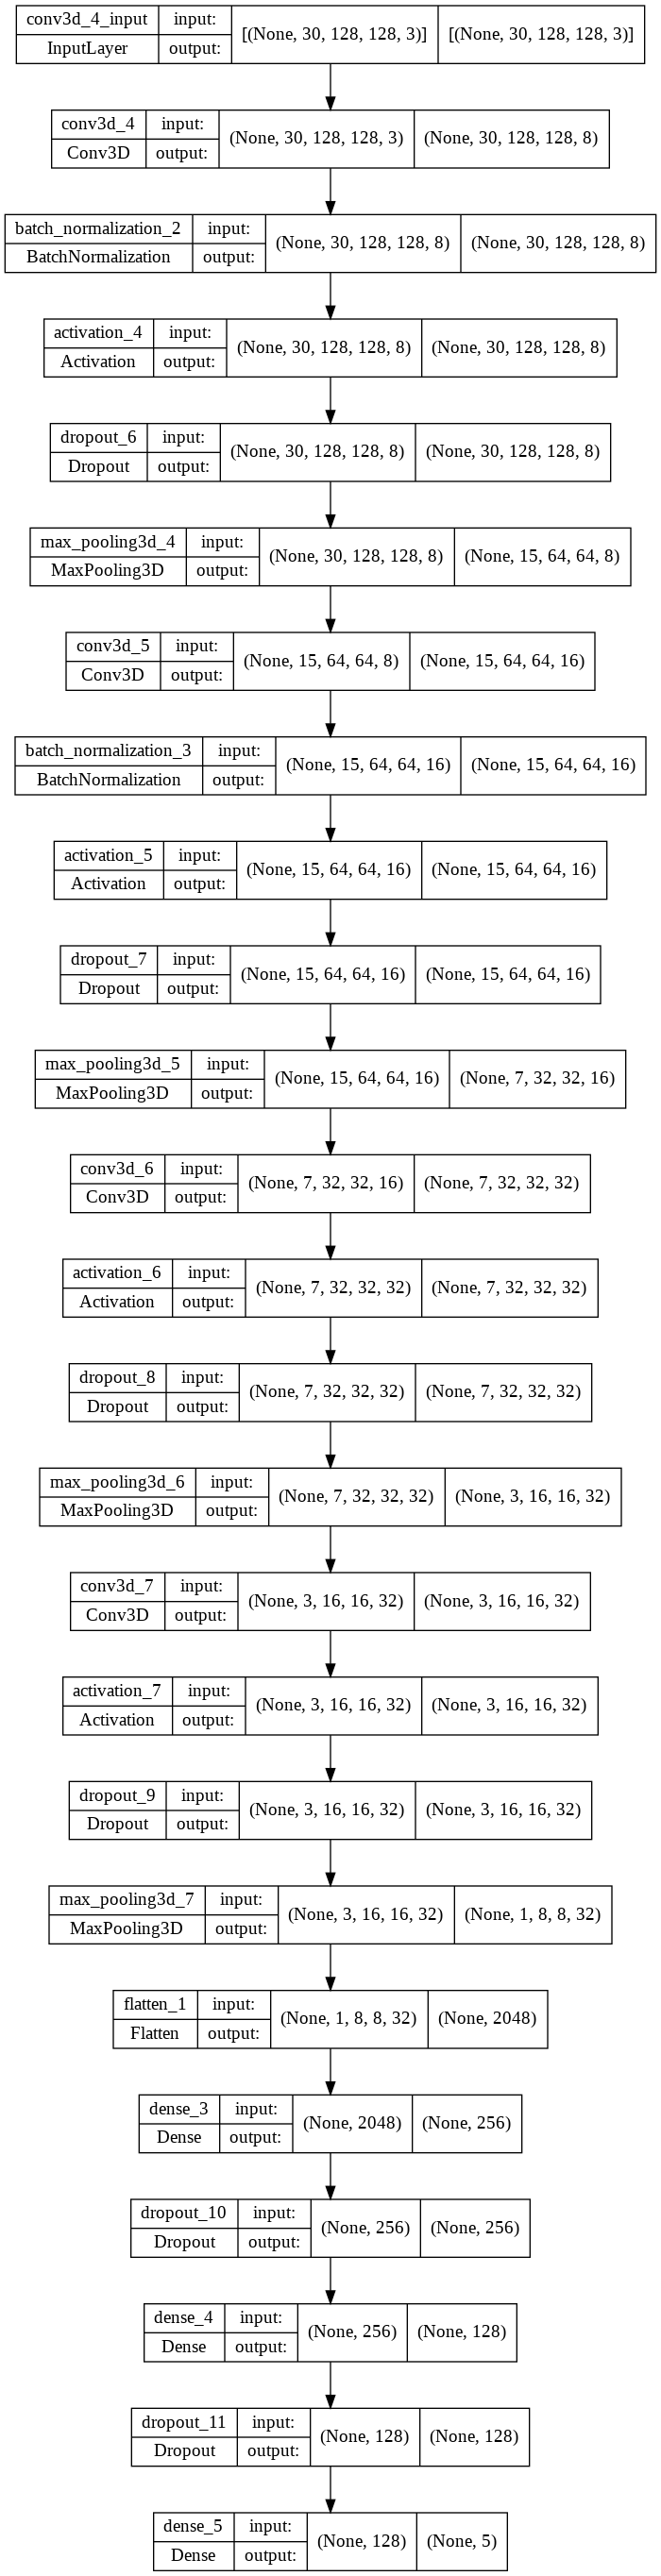

In [56]:
# to see the model summary in pictorial format
from tensorflow.keras.utils import plot_model
plot_model(cnn_model_1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [57]:
# the model with 15 epochs and 128*128
history_cnn_model1 = train_model(cnn_model_1)

Source path =  /content/sample_data/Project_data/train ; batch size = 64
Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 3.3962 - categorical_accuracy: 0.2036 Source path =  /content/sample_data/Project_data/val ; batch size = 64

Epoch 1: val_loss improved from inf to 1.61252, saving model to model_init_2022-07-1205_27_57.471173/model-00001-3.39625-0.20362-1.61252-0.19000.h5
11/11 [==============================] - 248s 23s/step - loss: 3.3962 - categorical_accuracy: 0.2036 - val_loss: 1.6125 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.6120 - categorical_accuracy: 0.1765 
Epoch 2: val_loss improved from 1.61252 to 1.61064, saving model to model_init_2022-07-1205_27_57.471173/model-00002-1.61199-0.17647-1.61064-0.21000.h5
11/11 [==============================] - 271s 27s/step - loss: 1.6120 - categorical_accuracy: 0.1765 - val_loss: 1.6106 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 

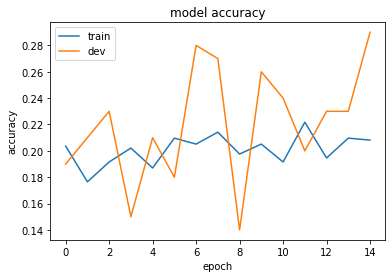

In [58]:
# plotting the graps of loss and accuracy
plot_accuracy(history_cnn_model1)

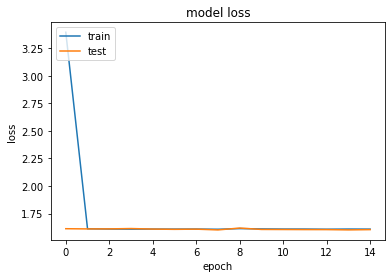

In [59]:
plot_loss(history_cnn_model1)

As model is performing very badly lets try different iteration

### Model 2

 "def cnn_3d(self,input_shape,no_classes):
      model = Sequential()
      model.add(Conv3D(16,kernel_size=(3,3,3),padding='same',input_shape=input_shape))
      model.add(BatchNormalization())
      model.add(Activation('relu'))
      #model.add(Dropout(0.25))

      model.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))

      model.add(Conv3D(32,kernel_size=(3,3,3),padding='same'))
      model.add(BatchNormalization())
      model.add(Activation('relu'))
      #model.add(Dropout(0.25))

      model.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))

      model.add(Conv3D(32,kernel_size=(1,3,3),padding='same'))
      model.add(Activation('relu'))
      #model.add(Dropout(0.25))

      model.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))

      model.add(Conv3D(64,kernel_size=(1,3,3),padding='same'))
      model.add(Activation('relu'))
      model.add(Dropout(0.25))

      model.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))

      #Flatten Layers
      model.add(Flatten())
      model.add(Dropout(0.25))

      model.add(Dense(128,activation='relu'))    

      model.add(Dense(64,activation='relu'))
      #model.add(Dropout(0.25))

      #Softmax Layer
      model.add(Dense(no_classes, activation='softmax'))
      return model"

In [72]:
# Model 2 with 15 epochs with 0.001 learning rate
model_class = ModelBuilding()
input_shape = (len([i for i in range(0,30)]),100,100,3)
no_classes = 5
optimiser = Adam(0.001)
cnn_model_2 = model_class.cnn_3d(input_shape,no_classes)
print(model_class.model_summary(cnn_model_2,optimiser))


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 100, 100, 16)  1312      
                                                                 
 batch_normalization_6 (Batc  (None, 30, 100, 100, 16)  64       
 hNormalization)                                                 
                                                                 
 activation_12 (Activation)  (None, 30, 100, 100, 16)  0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 15, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 15, 50, 50, 32)    13856     
                                                                 
 batch_normalization_7 (Batc  (None, 15, 50, 50, 32)  

In [73]:
# trainning the model with 15 epochs
history_cnn_model2 = train_model(cnn_model_2)

Source path =  /content/sample_data/Project_data/train ; batch size = 64
Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 1.7404 - categorical_accuracy: 0.2217 Source path =  /content/sample_data/Project_data/val ; batch size = 64

Epoch 1: val_loss improved from inf to 1.60034, saving model to model_init_2022-07-1206_47_43.999891/model-00001-1.74043-0.22172-1.60034-0.20000.h5
11/11 [==============================] - 254s 25s/step - loss: 1.7404 - categorical_accuracy: 0.2217 - val_loss: 1.6003 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.4618 - categorical_accuracy: 0.3665 
Epoch 2: val_loss did not improve from 1.60034
11/11 [==============================] - 258s 26s/step - loss: 1.4618 - categorical_accuracy: 0.3665 - val_loss: 1.6504 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 1.2569 - categorical_accuracy: 0.4661 
Epoc

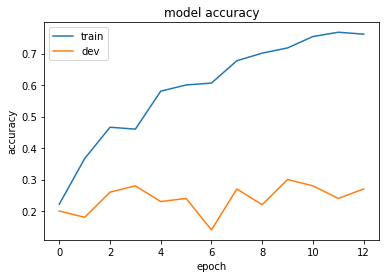

In [78]:
plot_accuracy(history_cnn_model2)

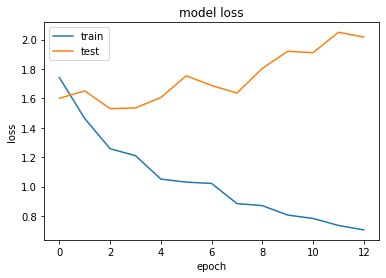

In [79]:
plot_loss(history_cnn_model2)

### Model 3 
*   Reducing number of frames
*   adding dropout and batchnormalization

model = Sequential()
      model.add(Conv3D(16,kernel_size=(3,3,3), input_shape=input_shape, activation = 'relu'))
      model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))
      model.add(BatchNormalization())
      model.add(Dropout(0.25))
      

      model.add(Conv3D(32,kernel_size=(3,3,3),activation = 'relu'))      
      model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))
      model.add(BatchNormalization())
      model.add(Dropout(0.25))


      model.add(Conv3D(64,kernel_size=(3,3,3),activation = 'relu'))
      model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))
      model.add(BatchNormalization())
      model.add(Dropout(0.25))     

      #Flatten Layers
      model.add(Flatten())

      model.add(Dense(128,activation='relu')) 
      model.add(BatchNormalization()) 
      model.add(Dropout(0.25))  

      model.add(Dense(64,activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(0.25))

      #Softmax Layer
      model.add(Dense(no_classes, activation='softmax'))
      return model



In [88]:
model_class = ModelBuilding()
input_shape = (len(getImgIdx(18)),100,100,3)
no_classes = 5
optimiser = Adam(0.002)
cnn_model_3 = model_class.cnn_3d(input_shape,no_classes)
print(model_class.model_summary(cnn_model_3,optimiser))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_22 (Conv3D)          (None, 16, 98, 98, 16)    1312      
                                                                 
 max_pooling3d_22 (MaxPoolin  (None, 8, 49, 49, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 8, 49, 49, 16)    64        
 chNormalization)                                                
                                                                 
 dropout_26 (Dropout)        (None, 8, 49, 49, 16)     0         
                                                                 
 conv3d_23 (Conv3D)          (None, 6, 47, 47, 32)     13856     
                                                                 
 max_pooling3d_23 (MaxPoolin  (None, 3, 24, 24, 32)   

In [89]:
#trainning the model with 15 epochs and learning rate 0.002
history_cnn_model3 = train_model(cnn_model_3)

Source path =  /content/sample_data/Project_data/train ; batch size = 64
Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 1.7340 - categorical_accuracy: 0.4208 Source path =  /content/sample_data/Project_data/val ; batch size = 64

Epoch 1: val_loss improved from inf to 3.32321, saving model to model_init_2022-07-1208_42_28.355021/model-00001-1.73400-0.42081-3.32321-0.21000.h5
11/11 [==============================] - 151s 15s/step - loss: 1.7340 - categorical_accuracy: 0.4208 - val_loss: 3.3232 - val_categorical_accuracy: 0.2100 - lr: 0.0020
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.2315 - categorical_accuracy: 0.5354 
Epoch 2: val_loss improved from 3.32321 to 1.60955, saving model to model_init_2022-07-1208_42_28.355021/model-00002-1.23149-0.53544-1.60955-0.34000.h5
11/11 [==============================] - 141s 14s/step - loss: 1.2315 - categorical_accuracy: 0.5354 - val_loss: 1.6096 - val_categorical_accuracy: 0.3400 - lr: 0.0020
Epoch 

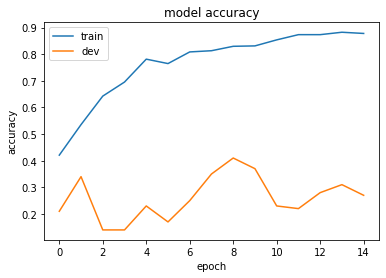

Max. Training Accuracy 0.8823529481887817
Max. Validaiton Accuracy 0.4099999964237213


In [92]:
plot_accuracy(history_cnn_model3)

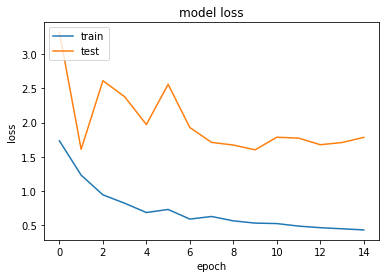

In [93]:
plot_loss(history_cnn_model3)

### Model 4

1.   Increasing number of epochs to 30
2.   Changing the Max Pooling size to 1,2,2
3.   Removing the learning rate for the model to decide
4.   Updating batch size to 32



In [127]:
input_shape = (len(getImgIdx(18)),100,100,3)
conv3d_model_4 = Sequential([
      (Conv3D(16,kernel_size=(3,3,3), input_shape=input_shape, activation = 'relu')),
      (MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same')),
      (BatchNormalization()),
      (Dropout(0.25)),
      

      Conv3D(32,kernel_size=(3,3,3),activation = 'relu'),      
      MaxPooling3D(pool_size=(1,2,2), strides=(2,2,2), padding='same'),
      BatchNormalization(),
      Dropout(0.25),


      Conv3D(64,kernel_size=(3,3,3),activation = 'relu'),
      MaxPooling3D(pool_size=(1,2,2), strides=(2,2,2), padding='same'),
      BatchNormalization(),
      Dropout(0.25),    

      #Flatten Layers
      Flatten(),

      Dense(128,activation='relu'),
      BatchNormalization(),
      Dropout(0.25),

      Dense(64,activation='relu'),
      BatchNormalization(),
      Dropout(0.25),

      #Softmax Layer
      Dense(no_classes, activation='softmax')
])

# COMPILE THE MODEL
conv3d_model_4.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(conv3d_model_4.summary())

# SETTING THE BATCH SIZE
batch_size = 32

# For training set
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# CREATING GENERATOR OBJECTS
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)


# FITTING THE MODEL
history_model_4 = conv3d_model_4.fit(train_generator,
          epochs=30,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_46 (Conv3D)          (None, 16, 98, 98, 16)    1312      
                                                                 
 max_pooling3d_46 (MaxPoolin  (None, 8, 49, 49, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_48 (Bat  (None, 8, 49, 49, 16)    64        
 chNormalization)                                                
                                                                 
 dropout_56 (Dropout)        (None, 8, 49, 49, 16)     0         
                                                                 
 conv3d_47 (Conv3D)          (None, 6, 47, 47, 32)     13856     
                                                                 
 max_pooling3d_47 (MaxPoolin  (None, 3, 24, 24, 32)  

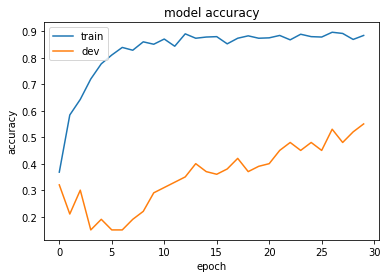

Max. Training Accuracy 0.8959276080131531
Max. Validaiton Accuracy 0.550000011920929


In [128]:
plot_accuracy(history_model_4)

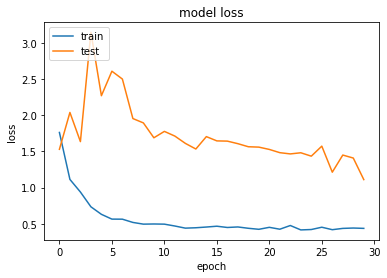

In [129]:
plot_loss(history_model_4)

### Model 5

Resizing the image to 84,84 and trying a smaller model

In [140]:
conv3d_model_5 = Sequential([
    Conv3D(16, (3,3,3),padding='same', input_shape=(len(getImgIdx(18)),84,84,3), activation='relu'),
    MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(32, (3,3,3),padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)),
    Conv3D(64, (3,3,3),padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)),
    Flatten(),
    Dense(64, activation='relu'),  # Last hidden layer neurons reduced to 64
    Dense(5, activation='softmax')
])

# COMPILE THE MODEL
conv3d_model_5.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(conv3d_model_5.summary())

# SETTING THE BATCH SIZE
batch_size = 32

# For training set
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# CREATING GENERATOR OBJECTS
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

# FITTING THE MODEL
history = conv3d_model_5.fit(train_generator,
          epochs=20,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_55 (Conv3D)          (None, 18, 84, 84, 16)    1312      
                                                                 
 max_pooling3d_55 (MaxPoolin  (None, 9, 42, 42, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_56 (Conv3D)          (None, 9, 42, 42, 32)     13856     
                                                                 
 max_pooling3d_56 (MaxPoolin  (None, 4, 21, 21, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_57 (Conv3D)          (None, 4, 21, 21, 64)     55360     
                                                                 
 max_pooling3d_57 (MaxPoolin  (None, 2, 10, 10, 64)  

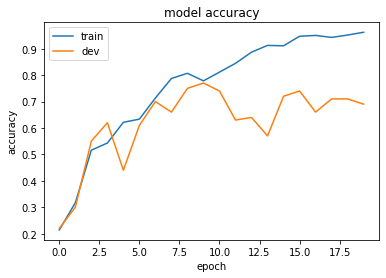

Max. Training Accuracy 0.9622926115989685
Max. Validaiton Accuracy 0.7699999809265137


In [141]:
plot_accuracy(history)

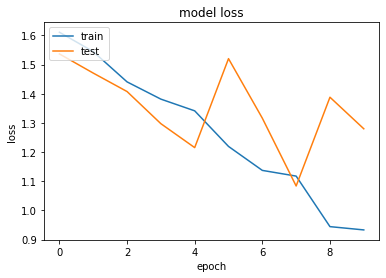

In [120]:
plot_loss(history)

### Model 6

In [135]:
input_shape = (len(getImgIdx(30)),84,84,3)
conv3d_model_6 = Sequential([
      (Conv3D(16,kernel_size=(3,3,3), input_shape=input_shape, activation = 'relu')),
      (MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same')),
      (BatchNormalization()),
      (Dropout(0.25)),
      

      Conv3D(32,kernel_size=(3,3,3),activation = 'relu'),      
      MaxPooling3D(pool_size=(1,2,2), strides=(2,2,2), padding='same'),
      BatchNormalization(),
      Dropout(0.25),


      Conv3D(64,kernel_size=(3,3,3),activation = 'relu'),
      MaxPooling3D(pool_size=(1,2,2), strides=(2,2,2), padding='same'),
      BatchNormalization(),
      Dropout(0.25),    

      #Flatten Layers
      Flatten(),

      Dense(128,activation='relu'),
      BatchNormalization(),
      Dropout(0.25),

      Dense(64,activation='relu'),
      BatchNormalization(),
      Dropout(0.25),

      #Softmax Layer
      Dense(no_classes, activation='softmax')
])

# COMPILE THE MODEL
conv3d_model_6.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(conv3d_model_6.summary())

# SETTING THE BATCH SIZE
batch_size = 32

# For training set
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# CREATING GENERATOR OBJECTS
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)


# FITTING THE MODEL
history_model_6 = conv3d_model_6.fit(train_generator,
          epochs=30,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_52 (Conv3D)          (None, 28, 82, 82, 16)    1312      
                                                                 
 max_pooling3d_52 (MaxPoolin  (None, 14, 41, 41, 16)   0         
 g3D)                                                            
                                                                 
 batch_normalization_58 (Bat  (None, 14, 41, 41, 16)   64        
 chNormalization)                                                
                                                                 
 dropout_66 (Dropout)        (None, 14, 41, 41, 16)    0         
                                                                 
 conv3d_53 (Conv3D)          (None, 12, 39, 39, 32)    13856     
                                                                 
 max_pooling3d_53 (MaxPoolin  (None, 6, 20, 20, 32)  

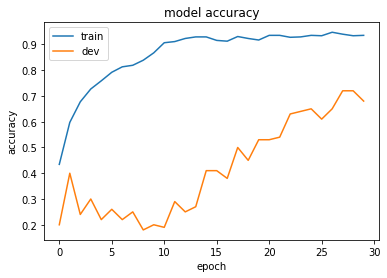

Max. Training Accuracy 0.9472096562385559
Max. Validaiton Accuracy 0.7200000286102295


In [137]:
plot_accuracy(history_model_6)

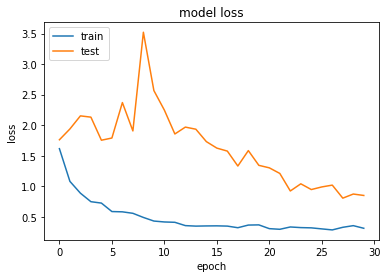

In [138]:
plot_loss(history_model_6)

### Model 7

In [143]:
input_shape = (len(getImgIdx(30)),84,84,3)
conv3d_model_7 = Sequential([
      (Conv3D(16,kernel_size=(5,5,5), input_shape=input_shape, activation = 'relu')),
      (MaxPooling3D(pool_size=(2,2,2), padding='same')),
      (BatchNormalization()),
      
      

      Conv3D(32,kernel_size=(3,3,3),activation = 'relu'),      
      MaxPooling3D(pool_size=(1,2,2),padding='same'),
      BatchNormalization(),
      


      Conv3D(64,kernel_size=(3,3,3),activation = 'relu'),
      MaxPooling3D(pool_size=(1,2,2),padding='same'),
      BatchNormalization(),
         

      #Flatten Layers
      Flatten(),

      Dense(128,activation='relu'),
      BatchNormalization(),
      Dropout(0.25),

      Dense(64,activation='relu'),
      BatchNormalization(),
      Dropout(0.25),

      #Softmax Layer
      Dense(no_classes, activation='softmax')
])

# COMPILE THE MODEL
conv3d_model_7.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(conv3d_model_7.summary())

# SETTING THE BATCH SIZE
batch_size = 32

# For training set
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# CREATING GENERATOR OBJECTS
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)


# FITTING THE MODEL
history_model_7 = conv3d_model_7.fit(train_generator,
          epochs=30,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_58 (Conv3D)          (None, 26, 80, 80, 16)    6016      
                                                                 
 max_pooling3d_58 (MaxPoolin  (None, 13, 40, 40, 16)   0         
 g3D)                                                            
                                                                 
 batch_normalization_63 (Bat  (None, 13, 40, 40, 16)   64        
 chNormalization)                                                
                                                                 
 conv3d_59 (Conv3D)          (None, 11, 38, 38, 32)    13856     
                                                                 
 max_pooling3d_59 (MaxPoolin  (None, 11, 19, 19, 32)   0         
 g3D)                                                            
                                                     

In [ ]:
plot_accuracy(history_model_7)

In [50]:
plot_loss(history_model_7)

NameError: ignored

### Building CNN + LSTM Model

In [46]:
from tensorflow.keras.applications import mobilenet
mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

17235968/17225924 [==============================] - 0s 0us/step


In [30]:
input_shape = (len(getImgIdx(30)),84,84,3)
print(input_shape)

(30, 84, 84, 3)


In [47]:
cnn_LSTM = Sequential([
    TimeDistributed(mobilenet, input_shape=input_shape)
], name="mobilenet_lstm")

for layer in cnn_LSTM.layers:
    layer.trainable = False

cnn_LSTM.add(TimeDistributed(BatchNormalization()))
cnn_LSTM.add(TimeDistributed(MaxPooling2D((2,2))))
cnn_LSTM.add(TimeDistributed(Flatten()))

cnn_LSTM.add(LSTM(256))
cnn_LSTM.add(Dropout(0.2))

cnn_LSTM.add(Dense(256,activation='relu'))
cnn_LSTM.add(Dropout(0.2))

cnn_LSTM.add(Dense(5, activation='softmax'))


In [48]:
# COMPILE THE MODEL
cnn_LSTM.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(cnn_LSTM.summary())

# SETTING THE BATCH SIZE
batch_size = 32

# For training set
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# CREATING GENERATOR OBJECTS
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)


# FITTING THE MODEL
history_CNN_LSTM = cnn_LSTM.fit(train_generator,
          epochs=30,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_99 (TimeDi  (None, 30, 2, 2, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_100 (TimeD  (None, 30, 2, 2, 1024)   4096      
 istributed)                                                     
                                                                 
 time_distributed_101 (TimeD  (None, 30, 1, 1, 1024)   0         
 istributed)                                                     
                                                                 
 time_distributed_102 (TimeD  (None, 30, 1024)         0         
 istributed)                                                     
                                                                 
 lstm (LSTM)                 (None, 256)            

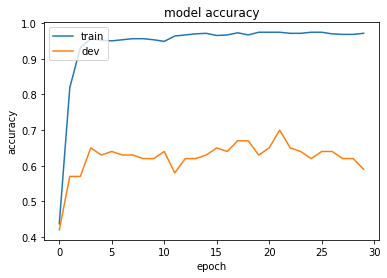

Max. Training Accuracy 0.9743589758872986
Max. Validaiton Accuracy 0.699999988079071


In [49]:
plot_accuracy(history_CNN_LSTM)

### Adding augmentation to my generator to see if it helps my model performance

In [93]:
def getImgIdx(n_frames):
  img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
  return img_idx
def generator(source_path, folder_list, batch_size,n_frames,augment=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = getImgIdx(n_frames) #create a list of image numbers you want to use for a particular video
    x = len(img_idx) #x is the number of images you use for each video
    y = 84 #(y,z) is the final size of the input images and 3 is the number of channels RGB
    z = 84 #(y,z) is the final size of the input images and 3 is the number of channels RGB
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            if (augment): batch_data_aug = np.zeros((batch_size,x,y,z,3)) # adding augment part of it to check the performance.
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                                       
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z)#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z)#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z)#normalise and feed in the image

                

                    if (augment):
                      shifted = cv.warpAffine(image, 
                                     np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),                                         (image.shape[1], image.shape[0]))
                    
                      gray = cv.cvtColor(shifted,cv.COLOR_BGR2GRAY)

                      x0, y0 = np.argwhere(gray > 0).min(axis=0)
                      x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                         # cropping the images to have the targeted gestures and remove the noise from the images.
                      cropped=shifted[x0:x1,y0:y1,:]
                      image_resized=imresize(cropped,(y,z,3))
                      batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                      batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                      batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

                if (augment):
                    batch_data=np.concatenate([batch_data,batch_data_aug])
                    batch_labels=np.concatenate([batch_labels,batch_labels])

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(folder_list)%batch_size != 0: # Finding total images procees
            remaining_batch_size = len(folder_list)%batch_size # finding remaining images to process
            batch_data = np.zeros((remaining_batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(remaining_batch_size): # iterate over remaining images
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*remaining_batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*remaining_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                   
                    batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z)#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z)#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z)#normalise and feed in the image

                    if (augment):
                      shifted = cv.warpAffine(image, 
                                     np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),                                         (image.shape[1], image.shape[0]))
                    
                      gray = cv.cvtColor(shifted,cv.COLOR_BGR2GRAY)

                      x0, y0 = np.argwhere(gray > 0).min(axis=0)
                      x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                         # cropping the images to have the targeted gestures and remove the noise from the images.
                      cropped=shifted[x0:x1,y0:y1,:]
                      image_resized=imresize(cropped,(y,z,3))
                      batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                      batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                      batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

                if (augment):
                    batch_data=np.concatenate([batch_data,batch_data_aug])
                    batch_labels=np.concatenate([batch_labels,batch_labels])

            yield batch_data, batch_labels


In [61]:
input_shape = (len(getImgIdx(18)),84,84,3)

CNN_LSTM_1 = Sequential([
    TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'), input_shape=input_shape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),
    TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),
    TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),
    TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),
    TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2,2))),
    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

In [62]:
# COMPILE THE MODEL
CNN_LSTM_1.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(CNN_LSTM_1.summary())

# SETTING THE BATCH SIZE
batch_size = 20
n_frames = 18

# For training set
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# CREATING GENERATOR OBJECTS
train_generator = generator(train_path,train_doc,batch_size,n_frames)
val_generator = generator(val_path,val_doc,batch_size,n_frames)


# FITTING THE MODEL
history_CNN_LSTM_1 = CNN_LSTM_1.fit(train_generator,
          epochs=30,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_135 (TimeD  (None, 18, 84, 84, 16)   448       
 istributed)                                                     
                                                                 
 time_distributed_136 (TimeD  (None, 18, 84, 84, 16)   64        
 istributed)                                                     
                                                                 
 time_distributed_137 (TimeD  (None, 18, 42, 42, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_138 (TimeD  (None, 18, 42, 42, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_139 (TimeD  (None, 18, 42, 42, 32) 

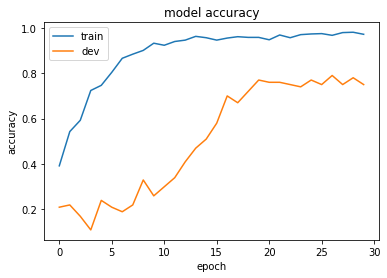

Max. Training Accuracy 0.9803921580314636
Max. Validaiton Accuracy 0.7900000214576721


In [64]:
plot_accuracy(history_CNN_LSTM_1)

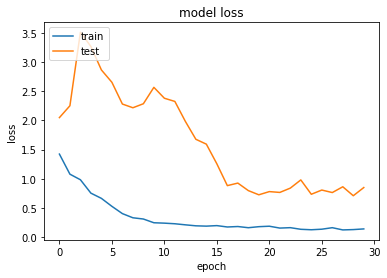

In [65]:
plot_loss(history_CNN_LSTM_1)

In [82]:
input_shape = (len(getImgIdx(18)),84,84,3)

CNN_LSTM_2 = Sequential([
    TimeDistributed(Conv2D(8, 3, padding='same', strides=(2,2), activation='relu'),input_shape = input_shape),

    TimeDistributed(Conv2D(16, 3, padding='same', strides=(2,2), activation='relu')),
    TimeDistributed(MaxPooling2D((2,2), strides=(1,1))),
    
    TimeDistributed(Conv2D(32, 3, padding='same', strides=(2,2), activation='relu')),
    TimeDistributed(MaxPooling2D((2,2), strides=(1,1))),
            
    TimeDistributed(Conv2D(64, 3, padding='same', strides=(2,2), activation='relu')),
    TimeDistributed(MaxPooling2D((2,2), strides=(1,1))),

    TimeDistributed(BatchNormalization()) ,  
    Dropout(0.5),

    TimeDistributed(Flatten()),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),

    LSTM(128),
    Dense(5, activation='softmax')
])

In [83]:
# COMPILE THE MODEL
CNN_LSTM_2.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(CNN_LSTM_2.summary())

# SETTING THE BATCH SIZE
batch_size = 20
n_frames = 18

# For training set
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# CREATING GENERATOR OBJECTS
train_generator = generator(train_path,train_doc,batch_size,n_frames)
val_generator = generator(val_path,val_doc,batch_size,n_frames)


# FITTING THE MODEL
history_CNN_LSTM_2 = CNN_LSTM_2.fit(train_generator,
          epochs=30,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_223 (TimeD  (None, 18, 42, 42, 8)    224       
 istributed)                                                     
                                                                 
 time_distributed_224 (TimeD  (None, 18, 21, 21, 16)   1168      
 istributed)                                                     
                                                                 
 time_distributed_225 (TimeD  (None, 18, 20, 20, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_226 (TimeD  (None, 18, 10, 10, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_227 (TimeD  (None, 18, 9, 9, 32)   

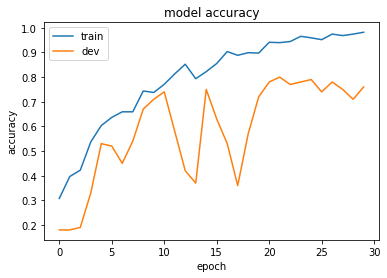

Max. Training Accuracy 0.9819004535675049
Max. Validaiton Accuracy 0.800000011920929


In [84]:
plot_accuracy(history_CNN_LSTM_2)

### Building CNN + GRU

Model with 84*84 Resize,30 EPochs and 20 Batch Size

In [94]:
input_shape = (len(getImgIdx(18)),84,84,3)

CNN_GRU = Sequential([
    TimeDistributed(Conv2D(8, 3, padding='same', strides=(2,2), activation='relu'),input_shape = input_shape),

    TimeDistributed(Conv2D(16, 3, padding='same', strides=(2,2), activation='relu')),
    TimeDistributed(MaxPooling2D((2,2),strides=(1,1))),
    
    TimeDistributed(Conv2D(32, 3, padding='same', strides=(2,2), activation='relu')),
    TimeDistributed(MaxPooling2D((2,2),strides=(1,1))),
            
    TimeDistributed(Conv2D(64, 3, padding='same', strides=(2,2), activation='relu')),
    TimeDistributed(MaxPooling2D((2,2),strides=(1,1))),

    TimeDistributed(BatchNormalization()) ,  
    Dropout(0.5),

    TimeDistributed(Flatten()),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),

    GRU(128),
    Dense(5, activation='softmax')
])

In [95]:
# COMPILE THE MODEL
CNN_GRU.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(CNN_GRU.summary())

# SETTING THE BATCH SIZE
batch_size = 20
n_frames = 18

# For training set
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# CREATING GENERATOR OBJECTS
train_generator = generator(train_path,train_doc,batch_size,n_frames)
val_generator = generator(val_path,val_doc,batch_size,n_frames)


# FITTING THE MODEL
history_CNN_GRU = CNN_GRU.fit(train_generator,
          epochs=30,
          callbacks=callbacks_list,
          validation_data=val_generator, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_259 (TimeD  (None, 18, 42, 42, 8)    224       
 istributed)                                                     
                                                                 
 time_distributed_260 (TimeD  (None, 18, 21, 21, 16)   1168      
 istributed)                                                     
                                                                 
 time_distributed_261 (TimeD  (None, 18, 20, 20, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_262 (TimeD  (None, 18, 10, 10, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_263 (TimeD  (None, 18, 9, 9, 32)   

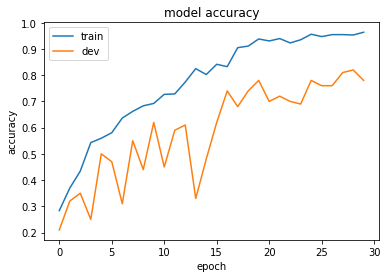

Max. Training Accuracy 0.9638009071350098
Max. Validaiton Accuracy 0.8199999928474426


In [96]:
plot_accuracy(history_CNN_GRU)

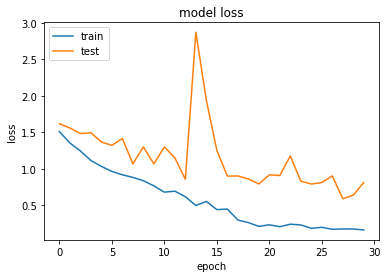

In [97]:
plot_loss(history_CNN_GRU)